In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# اجرای کد برای شناسایی بهترین epoch و ذخیره لایه ها

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import ImageFilter, Image
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score
import os
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# تنظیمات اولیه PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# دیتاست سفارشی برای خواندن تصاویر و لیبل‌ها
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(f"{self.img_dir}/{img_name}")
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label
def remove_noise(image):
    return image.filter(ImageFilter.MedianFilter(size=3))  # استفاده از MedianFilter برای حذف نویز

def increase_sharpness(image):
    return image.filter(ImageFilter.UnsharpMask(radius=2, percent=100))
# تبدیل‌های لازم برای تصاویر شامل نرمال‌سازی
transform = transforms.Compose([
    transforms.Lambda(lambda img: remove_noise(img)),      # حذف نویز
    transforms.Lambda(lambda img: increase_sharpness(img)),# افزایش وضوح
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.CenterCrop(300),

])

# خواندن دیتاست
csv_file = '/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif/augmented_labels.csv'  # آدرس فایل CSV
img_dir = '/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif'  # آدرس پوشه تصاویر

dataset = CustomDataset(csv_file, img_dir, transform=transform)

# تقسیم داده‌ها به آموزش و تست
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# مدل EfficientNetv2s با لایه خروجی باینری
class BinaryEfficientNet(nn.Module):
    def __init__(self):
        super(BinaryEfficientNet, self).__init__()
        self.model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

        # فریز کردن لایه‌های اولیه
        for param in self.model.features.parameters():
            param.requires_grad = False

        # تغییر لایه آخر به باینری
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)  # دو کلاس (باینری)

    def forward(self, x):
        return self.model(x)

model = BinaryEfficientNet().to(device)

# تابع از دست دادن و بهینه‌سازی
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# تابع آموزش
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# تابع تست و ارزیابی
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# آموزش مدل
train_model(model, criterion, optimizer, train_loader, num_epochs=10)

# ارزیابی مدل
evaluate_model(model, test_loader)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 103MB/s]


Epoch [1/10], Loss: 0.6393
Epoch [2/10], Loss: 0.5762
Epoch [3/10], Loss: 0.5558
Epoch [4/10], Loss: 0.5235
Epoch [5/10], Loss: 0.5253
Epoch [6/10], Loss: 0.5200
Epoch [7/10], Loss: 0.5106
Epoch [8/10], Loss: 0.5108
Epoch [9/10], Loss: 0.5121


In [ ]:
epoch =128
بدون نرمال‌سازی
Epoch [14/15], Loss: 0.4948
Epoch [15/15], Loss: 0.4977
Accuracy: 0.7692, Recall: 0.8259, F1 Score: 0.7816

# نتایج کد بالا با نرمالایز     transforms.Normalize([0.250, 0.210, 0.210],
                         [0.109, 0.124, 0.125])


                         Epoch [14/15], Loss: 0.5072
Epoch [15/15], Loss: 0.5008
Accuracy: 0.8279, Recall: 0.8943, F1 Score: 0.8479

In [ ]:

# تنظیمات اولیه PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# دیتاست سفارشی برای خواندن تصاویر و لیبل‌ها
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(f"{self.img_dir}/{img_name}")
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# تبدیل‌های لازم برای تصاویر شامل نرمال‌سازی
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.CenterCrop(300),
    transforms.Normalize([0.250, 0.210, 0.210],
                         [0.109, 0.124, 0.125])
])

# خواندن دیتاست
csv_file = '/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif/augmented_labels.csv'  # آدرس فایل CSV
img_dir = '/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif'  # آدرس پوشه تصاویر

dataset = CustomDataset(csv_file, img_dir, transform=transform)

# تقسیم داده‌ها به آموزش و تست
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# مدل EfficientNetv2s با لایه خروجی باینری
class BinaryEfficientNet(nn.Module):
    def __init__(self):
        super(BinaryEfficientNet, self).__init__()
        self.model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

        # فریز کردن لایه‌های اولیه
        for param in self.model.features.parameters():
            param.requires_grad = False

        # تغییر لایه آخر به باینری
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)  # دو کلاس (باینری)

    def forward(self, x):
        return self.model(x)

model = BinaryEfficientNet().to(device)

# تابع از دست دادن و بهینه‌سازی
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# تابع آموزش
def train_model(model, criterion, optimizer, train_loader, num_epochs=16):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# تابع تست و ارزیابی
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# آموزش مدل
train_model(model, criterion, optimizer, train_loader, num_epochs=16)

# ارزیابی مدل
evaluate_model(model, test_loader)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 144MB/s]


Epoch [1/16], Loss: 0.6147
Epoch [2/16], Loss: 0.5378
Epoch [3/16], Loss: 0.5227
Epoch [4/16], Loss: 0.5133
Epoch [5/16], Loss: 0.5086
Epoch [6/16], Loss: 0.4975
Epoch [7/16], Loss: 0.5120
Epoch [8/16], Loss: 0.4910
Epoch [9/16], Loss: 0.4845
Epoch [10/16], Loss: 0.4751
Epoch [11/16], Loss: 0.4910
Epoch [12/16], Loss: 0.4847
Epoch [13/16], Loss: 0.4826
Epoch [14/16], Loss: 0.4890
Epoch [15/16], Loss: 0.4723
Epoch [16/16], Loss: 0.4762
Accuracy: 0.8138, Recall: 0.8967, F1 Score: 0.8251


# نمونه مهم با تغییر سایز و نرمالسازی بهینه

In [ ]:

# تنظیمات اولیه PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# دیتاست سفارشی برای خواندن تصاویر و لیبل‌ها
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(f"{self.img_dir}/{img_name}")
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# تابع برای اعمال فیلتر Gaussian به تصویر
def gaussian_blur(image):
    # تبدیل Tensor به numpy array
    image = np.array(image)

    # اعمال فیلتر Gaussian
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # تبدیل numpy array به Tensor
    image = torch.tensor(image)

    return image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.CenterCrop(300),
    transforms.Lambda(gaussian_blur),  # اعمال فیلتر Gaussian
    transforms.Normalize([0.100, 0.250, 0.270],
                         [0.109, 0.124, 0.125])
])

# خواندن دیتاست
csv_file = '/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif/augmented_labels.csv'  # آدرس فایل CSV
img_dir = '/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif'  # آدرس پوشه تصاویر

dataset = CustomDataset(csv_file, img_dir, transform=transform)

# تقسیم داده‌ها به آموزش و تست
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# مدل EfficientNetv2s با لایه خروجی باینری
class BinaryEfficientNet(nn.Module):
    def __init__(self):
        super(BinaryEfficientNet, self).__init__()
        self.model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

        # فریز کردن لایه‌های اولیه
        for param in self.model.features.parameters():
            param.requires_grad = False

        # تغییر لایه آخر به باینری
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)  # دو کلاس (باینری)

    def forward(self, x):
        return self.model(x)

model = BinaryEfficientNet().to(device)

# تابع از دست دادن و بهینه‌سازی
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# تابع آموزش
def train_model(model, criterion, optimizer, train_loader, num_epochs=16):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# تابع تست و ارزیابی
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# آموزش مدل
train_model(model, criterion, optimizer, train_loader, num_epochs=16)

# ارزیابی مدل
evaluate_model(model, test_loader)


Epoch [1/16], Loss: 0.6080
Epoch [2/16], Loss: 0.5227
Epoch [3/16], Loss: 0.5027
Epoch [4/16], Loss: 0.5001
Epoch [5/16], Loss: 0.4789
Epoch [6/16], Loss: 0.4848
Epoch [7/16], Loss: 0.4716
Epoch [8/16], Loss: 0.4735
Epoch [9/16], Loss: 0.4554
Epoch [10/16], Loss: 0.4685
Epoch [11/16], Loss: 0.4701
Epoch [12/16], Loss: 0.4694
Epoch [13/16], Loss: 0.4626
Epoch [14/16], Loss: 0.4492
Epoch [15/16], Loss: 0.4473
Epoch [16/16], Loss: 0.4664
Accuracy: 0.7935, Recall: 0.8554, F1 Score: 0.8068


In [ ]:
Epoch [20/20], Loss: 0.4811
Accuracy: 0.8462, Recall: 0.8819, F1 Score: 0.8550

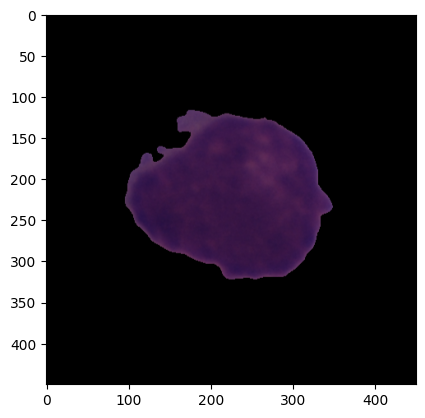

torch.Size([3, 300, 300])


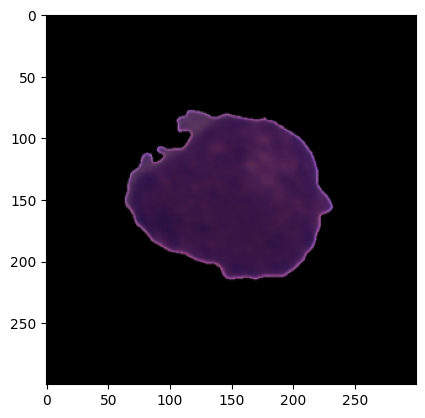

In [ ]:
def remove_noise(image):
    return image.filter(ImageFilter.MedianFilter(size=3))  # استفاده از MedianFilter برای حذف نویز

def increase_sharpness(image):
    return image.filter(ImageFilter.UnsharpMask(radius=2, percent=250))
cell = Image.open('/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif/16.tif')
plt.imshow(cell)
plt.show()
transform = transforms.Compose([
    transforms.Lambda(lambda img: remove_noise(img)),      # حذف نویز
    transforms.Lambda(lambda img: increase_sharpness(img)),# افزایش وضوح
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.CenterCrop(300),

])
im = transform(cell)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [ ]:
  transforms.Normalize([0.280, 0.250, 0.200],
                         [0.109, 0.124, 0.125])

([0.0835, 0.0419, 0.0868]),
([0.1464, 0.0760, 0.1513])

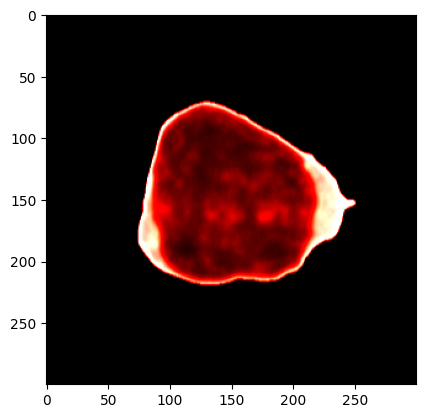

In [ ]:
cell = Image.open('/content/drive/MyDrive/دانشگاه/دیتاست/PKG - C-NMC 2019/C-NMC_test_prelim_tif/1116.tif')
# تابع برای اعمال فیلتر Gaussian به تصویر
def gaussian_blur(image):
    # تبدیل Tensor به numpy array
    image = np.array(image)

    # اعمال فیلتر Gaussian
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # تبدیل numpy array به Tensor
    image = torch.tensor(image)

    return image

# اعمال فیلتر و نرمال‌سازی
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300,300)),
    transforms.CenterCrop(300),
    transforms.Lambda(gaussian_blur),  # اعمال فیلتر Gaussian
    transforms.Normalize([0.100, 0.250, 0.270],
                         [0.109, 0.124, 0.125])
])

# استفاده از ترنسفرم
normalized_image = transform(cell)

# نمایش تصویر نهایی
import matplotlib.pyplot as plt
plt.imshow(normalized_image.permute(1, 2, 0).numpy())
plt.show()
